# 학생을 위한 카풀 형태의 셔틀버스 시스템

## 목차

1. 개요
  
2. 분석 준비 

3. 분석 - 가설 1 검증; 10대 학생의 교통이용 패턴이 다른 연령대의 집단과 시간적 동선이 많이 겹친다

4. 분석 - 가설 2 검증; 10대 학생의 코로나 확진의 주 원인은 타인으로부터의 감염이고, 최초 감염자인 10대는 타 연령대에 비해 클러스터의 규모가 작다

5. 정책 제안 및 기대효과
  

---

## 개요
코로나19로 인해 2020년에는 최대 40% 정도의 지하철 및 버스의 사용량이 감소하였다.

버스 및 지하철의 사용량은 지하철과 버스가 감염의 주요 경로가 될 수 있기 때문에 감소한 것으로 추정된다.

물론 서울시의 사례( http://mediahub.seoul.go.kr/archives/1284399 )로 볼 때 버스와 지하철은 코로나에 상대적으로 안전한 것으로 확인된다.

하지만 최근의 뉴스( https://newsis.com/view/?id=NISX20200826_0001143772&cID=10201&pID=10200 )에 따르면, 지하철 및 버스 내에서 마스크를 쓰지 않는 사람들이 존재한다.

또한 데이터에 따르면 버스와 지하철의 사용량은 생각보다 빠른 속도로 회복되고 있음을 알 수 있었다.

이러한 결과로 인해 버스와 지하철이 새로운 감염원이 될 확률은 점점 증가하고 있다.

이에 따라 본 프로젝트에서는 10대 학생의 대중교통 이용 패턴과 연령대에 따라서 코로나 확진자 수의 발생 패턴에 대해 알아보고자 우리는 총 2가지 가설을 검증하고자 한다.

- 가설 1 : 10대 학생의 교통이용 패턴이 다른 연령대의 집단과 시간적 동선이 많이 겹친다.
- 가설 2 : 10대 학생의 코로나 확진의 주 원인은 타인으로부터의 감염이고, 최초 감염자인 10대는 타 연령대에 비해 클러스터의 규모가 작다.

이러한 가설의 검증을 바탕으로 우리는 10대 학생(초, 중, 고)을 대상으로 학교를 오고 갈 때, 학생들만을 대상으로 한 카풀형태의 셔틀버스 시스템을 제안하고자 한다.

그리고 해당 시스템이 적용된 예시로 서울시 내 예상경로를 만들 예정이다.

---

## 분석 준비

### 라이브러리
본 프로젝트에서는 분석을 위해 다음과 같은 라이브러리를 사용하였다.

- cudf
- dask
- pandas
- numpy
- sklearn
- seaborn
- matplotlib

특히, cudf와 dask같은 경우는 각각 gpu와 multiprocess를 pandas에 적용시킨 라이브러리로 기존의 pandas를 이용하는 것 보다 훨씬 효율적인 데이터처리를 가능하게 해주었다.

In [1]:
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster(local_directory="/tmp/kkong_don")
client = Client(cluster)

import cudf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import umap

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="NanumBarunGothic", size=15)
import calmap
import squarify

from collections import Counter

from tqdm.notebook import tqdm

/opt/miniconda3/envs/BigData/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40261 instead
  http_address["port"], self.http_server.port


### 데이터 처리를 위한 함수

아래의 helper들은 데이터 처리를 위해 만들어졌다.

아래 제시될 결과에 따르면 주말과 주중의 이용양상이 다름을 알 수 있었다.

이를 해결하기 위해선 2019년과 2020년에서 요일을 맞추어줄 필요가 있었다.

이를 위해 아래 helper들이 만들어졌다.

to_week_array는 1월 1일부터 시작되는 데이터가 존재할 때, 이를 각 행은 한 주, 각 열은 요일을 뜻하는 배열로 형태를 바꾸어 준다.

mask_and_sum은 일별 데이터를 통계를 내어 주별 데이터로 바꾸어 준다. 이때, 인풋으로 들어온 두 배열 각각 값을 가지는 부분만 가져와서 마스킹 후 계산한다.

In [2]:
def to_week_array(*args, offset=0):
    if len(args)==0:
        raise TypeError("Function takes at least 1 positional arguments (0 given)")
    num_weeks = (len(args[0])+offset-1)//7 + 1
    ans = []
    len_arr_in_args = len(args[0])
    for arr in args:
        if len(arr)!=len_arr_in_args:
            raise TypeError("Not all of positional arguments are same length")
        arr1 = np.zeros((num_weeks * 7), dtype=np.int64)
        arr1[offset:offset+len(arr)] = arr
        arr1 = arr1.reshape((num_weeks,7))
        ans.append(arr1)
    if len(ans)==1:
        return ans[0]
    else:
        return tuple(ans)

In [3]:
def mask_and_sum(_np1, _np2):
    if _np1.shape[0]!=_np2.shape[0]:
        min_num = min(_np1.shape[0], _np2.shape[0])
        np1, np2 = _np1[:min_num, :], _np2[:min_num, :]
    else:
        np1, np2 = _np1, _np2
    mask1 = np1 !=0
    mask2 = np2 !=0

    mask = np.logical_and(mask1, mask2)
    div = np.sum(mask, axis=1)
    arr1 = np.sum(np1*mask, axis=1)
    arr2 = np.sum(np2*mask, axis=1)
    
    return arr1/div, arr2/div

모든 주 단위 데이터는 크기가 (22, 7)인 행렬로 처리될 예정이다. 첫 번째 차원은 각 주에 대한 행이고, 열은 요일을 의미한다.

### 교통카드 사용 데이터

우리는 가설 1의 분석을 위해서 교통카드 사용 데이터를 이용하였다. 이를 위해서 다음과 같이 데이터를 불러오고, 2019년과 2020년 사이에 있는 주일의 주기를 맞추었다.

In [4]:
DM_PUBTRF_USESTF_T_column_names = ["년도", "년월", "운행 일자", "요일 구분", "이용자 유형 코드", "정산사 ID", "정산 지역 코드",\
                                   "교통수단 구분 코드", "노선 ID", "정류장 ID", "시도 코드", "시군구 코드", "이용 지역 코드", "이용 인원"]
DM_PUBTRF_USESTF_T = dask_cudf.read_csv("data/CARD/DM_PUBTRF_USESTF_T.dat", sep="|", header=None, names=DM_PUBTRF_USESTF_T_column_names).repartition(npartitions=100)
data_with_trans_type_and_region = DM_PUBTRF_USESTF_T[["운행 일자", "교통수단 구분 코드", "이용 인원", "시도 코드"]].groupby(["운행 일자", "교통수단 구분 코드", "시도 코드"]).sum().compute()
data_with_trans_type_and_region.reset_index(inplace=True)
data_with_trans_type_and_region

/opt/miniconda3/envs/BigData/lib/python3.6/site-packages/fsspec/implementations/local.py:33: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


,운행 일자,교통수단 구분 코드,시도 코드,이용 인원
0,20200313,B,41,1431854
1,20200205,T,47,7669
2,20190427,T,29,18385
3,20190425,B,47,157491
4,20190325,~,43,8283
...,...,...,...,...
9540,20190217,B,26,419001
9541,20200323,B,29,113721
9542,20200224,B,47,52800
9543,20200109,B,28,436414


In [5]:
Total_data = data_with_trans_type_and_region[["운행 일자", "이용 인원"]].groupby("운행 일자").sum().sort_index()
Bus_data = data_with_trans_type_and_region.loc[data_with_trans_type_and_region["교통수단 구분 코드"]=="B", ["운행 일자", "이용 인원"]].groupby("운행 일자").sum().sort_index()
Metro_data = data_with_trans_type_and_region.loc[data_with_trans_type_and_region["교통수단 구분 코드"]=="T", ["운행 일자", "이용 인원"]].groupby("운행 일자").sum().sort_index()

offset_2019 = 1 # 2019년은 1월1일이 화요일임
offset_2020 = 2 # 2020년은 1월1일이 수요일임

# 1st axis: 주, 2nd axis: 요일(월, 화, 수, 목, 금, 토, 일), 3rd axis: 총합, 버스, 지하철
data_card_2019 = np.zeros((22*7, 3), dtype=np.int64)
# 1st axis: 주, 2nd axis: 요일(월, 화, 수, 목, 금, 토, 일), 3rd axis: 총합, 버스, 지하철
data_card_2020 = np.zeros((22*7, 3), dtype=np.int64) 

In [6]:
tot_array_2019 = Total_data.iloc[:151, :].as_matrix()[:, 0]
bus_array_2019 = Bus_data.iloc[:151, :].as_matrix()[:, 0]
met_array_2019 = Metro_data.iloc[:151, :].as_matrix()[:, 0]

tot_array_2019, bus_array_2019, met_array_2019 = to_week_array(tot_array_2019, bus_array_2019, met_array_2019, offset=offset_2019)

tot_array_2020 = Total_data.iloc[151:, :].as_matrix()[:, 0]
bus_array_2020 = Bus_data.iloc[151:, :].as_matrix()[:, 0]
met_array_2020 = Metro_data.iloc[151:, :].as_matrix()[:, 0]

tot_array_2020, bus_array_2020, met_array_2020 = to_week_array(tot_array_2020, bus_array_2020, met_array_2020, offset=offset_2020)

### 정류장별 이용량 데이터

또한, 우리는 가설 1의 분석을 위해서 정류장별 이용량 데이터를 이용하였다. 이를 위해서 다음과 같이 데이터를 불러오고, 정리하였다.

In [7]:
area2code = {
    "서울": 11,
    "부산": 26,
    "대구": 27,
    "인천": 28,
    "광주": 29,
    "대전": 30,
    "울산": 31,
    "세종": 36,
    "경기": 41,
    "강원": 42,
    "충북": 43,
    "충남": 44,
    "전북": 45,
    "전남": 46,
    "경북": 47,
    "경남": 48,
    "제주": 50,
}
code2area = {
    11: "서울",
    26: "부산",
    27: "대구",
    28: "인천",
    29: "광주",
    30: "대전",
    31: "울산",
    36: "세종",
    41: "경기",
    42: "강원",
    43: "충북",
    44: "충남",
    45: "전북",
    46: "전남",
    47: "경북",
    48: "경남",
    50: "제주"
}

In [8]:
DM_STTNBY_USECNT_T_column_names = ["년도", "년월", "운행 일자", "요일 구분", "시간대", "이용자 유형 코드", "정산사 ID", "정산 지역 코드", "교통수단 구분 코드", \
                                   "정류장 ID", "시도 코드", "시군구 코드", "이용 지역 코드", "승차 인원", "하차 인원"]
dtype_dict = dict()
for name in DM_STTNBY_USECNT_T_column_names:
    if name == "이용자 유형 코드":
        dtype_dict[name]= 'str'
        continue
    if name == "교통수단 구분 코드":
        dtype_dict[name]= 'str'
        continue
    dtype_dict[name]= 'int64'

DM_STTNBY_USECNT_T = dask_cudf.read_csv("data/CARD/DM_STTNBY_USECNT_T.dat", sep="|", header=None, names=DM_STTNBY_USECNT_T_column_names, dtype=dtype_dict)
DM_STTNBY_USECNT_T["이용자 유형 코드"] = DM_STTNBY_USECNT_T["이용자 유형 코드"].replace("~", "99").astype("int8")

data_reduced = DM_STTNBY_USECNT_T.loc[DM_STTNBY_USECNT_T["시도 코드"]==area2code["서울"], :]
data_reduced = data_reduced[["운행 일자", "시간대", "이용자 유형 코드", "승차 인원", "하차 인원"]].groupby(["운행 일자", "시간대", "이용자 유형 코드"]).sum().compute()
data_reduced.reset_index(inplace=True)

In [9]:
DM_TFBY_USEV_SMY_column_names = ["운행 일자", "시도 코드", "시군구 코드", "교통수단 코드", "이용 건수"]
DM_TFBY_USEV_SMY = pd.read_csv("data/CARD/DM_TFBY_USEV_SMY.dat", sep="|", header=None, names=DM_TFBY_USEV_SMY_column_names)
date_list = sorted(DM_TFBY_USEV_SMY["운행 일자"].unique())[:151]

---

## 분석 - 가설 1 검증

### 버스 및 지하철 이용량 분석 및 회복 양상 예측

먼저 우리는 시민들의 2019년과 2020년의 버스 및 지하철 이용량 차이를 분석하고, 이에 따라 2020년의 버스 및 지하철 이용량의 회복양상을 예측하고자 한다.

이를 위해서 가장 먼저 2019년, 2020년의 전체, 버스 그리고 지하철 이용 인원이 어떻게 다른지 분석하였다.


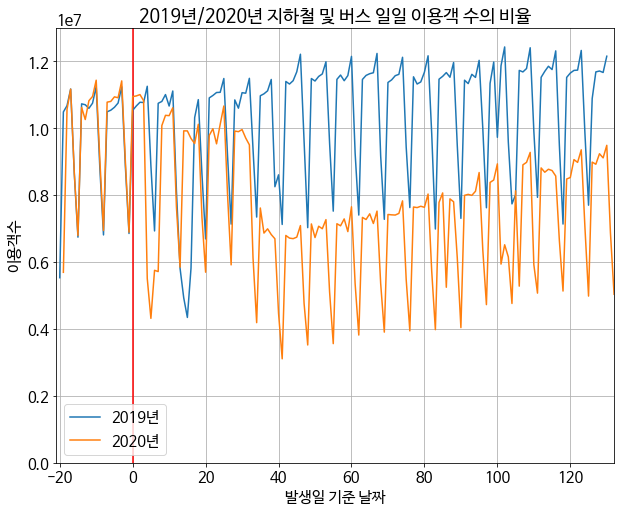

In [10]:
plot2019 = np.where(tot_array_2019==0, np.nan, tot_array_2019.astype(np.float64))
plot2020 = np.where(tot_array_2020==0, np.nan, tot_array_2020.astype(np.float64))

idx_1_20 = offset_2020-1+20
x_max = len(plot2019.ravel())-1

fig = plt.figure(figsize=(10,8))
plt.plot(plot2019.ravel(), label="2019년")
plt.plot(plot2020.ravel(), label="2020년")
plt.vlines(idx_1_20, ymin=0, ymax = 1.3e7, color="red")
plt.grid()
plt.legend()
plt.xlim(xmin=0, xmax = x_max)
plt.ylim(ymin=0, ymax = 1.3e7)
plt.xticks(range(idx_1_20-20, 151, 20), range(-20,151-20, 20))
plt.xlabel("발생일 기준 날짜")
plt.ylabel("이용객수")
_ = plt.title("2019년/2020년 지하철 및 버스 일일 이용객 수의 비율")

위 그래프와 같이 여러 스파이크가 나오게 되는데, 이는 주말과 주중의 이동 특성이 다르기 때문에 발생하는 것이다.

이에 더해 버스와 지하철 데이터에 대해서도 비교해보자.

다음 데이터는 해석의 편의를 위해 2020년/2019년으로 2020년 데이터에 2019년을 나누어 처리했다.

/opt/miniconda3/envs/BigData/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/BigData/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/BigData/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/miniconda3/envs/BigData/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


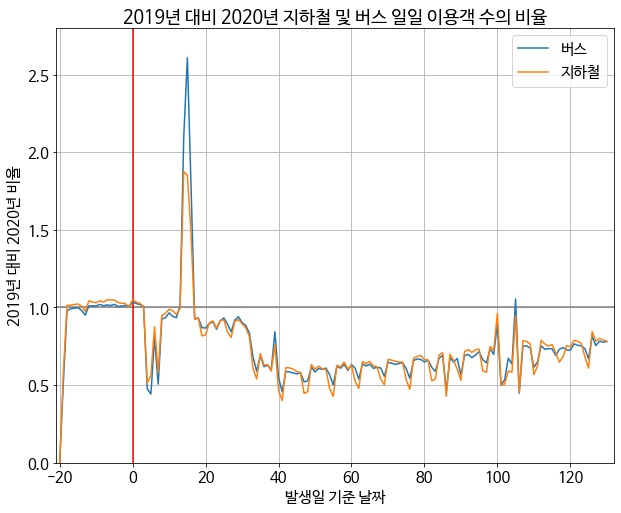

In [11]:
ratio_bus = bus_array_2020.astype(np.float64).ravel()/bus_array_2019.astype(np.float64).ravel()
ratio_met = met_array_2020.astype(np.float64).ravel()/met_array_2019.astype(np.float64).ravel()
x_max = len(ratio_bus)-1
fig = plt.figure(figsize=(10,8))
plt.plot(ratio_bus, label="버스")
plt.plot(ratio_met, label="지하철")
plt.hlines(1, xmin=0, xmax=x_max, color="grey")
plt.vlines(idx_1_20, ymin=0, ymax = 2.8, color="red")
plt.grid()
plt.legend()
plt.xlim(xmin=0, xmax=x_max)
plt.ylim(ymin=0, ymax = 2.8)
plt.xticks(range(idx_1_20-20, 151, 20), range(-20,151-20, 20))
plt.xlabel("발생일 기준 날짜")
plt.ylabel("2019년 대비 2020년 비율")
_ = plt.title("2019년 대비 2020년 지하철 및 버스 일일 이용객 수의 비율")

0일에서 20일 사이에 존재하는 스파이크는 두 년도에 구정의 기간 차이로 생기는 것으로 다른 경우와 달리 구정은 윤년으로 계산하기 때문에 발생한 문제이다.

또한 버스와 지하철 두 경우가 서로 다른 경향을 가지고 있지 않음을 확인하였다.

다음으로는 각 지역별로 어떻게 변화했는지 보여주는 boxplot이다.

각 주에 지역별 증감률을 계산한 다음 각 주별로 boxplot을 그린 후, 시간에 따라 배열하여 그렸다.

In [12]:
region_list = []
data_region_2019 = []
data_region_2020 = []
for idx, (code, name) in enumerate(code2area.items()):
    region_data = data_with_trans_type_and_region.loc[data_with_trans_type_and_region["시도 코드"]==code, ["운행 일자", "이용 인원"]].groupby("운행 일자").sum().sort_index()
    arr_2019 = region_data.iloc[:151, :].as_matrix()[:, 0]
    arr_2020 = region_data.iloc[151:, :].as_matrix()[:, 0]
    tmp = to_week_array(arr_2019, offset=offset_2019)
    data_region_2019.append(tmp)
    tmp = to_week_array(arr_2020, offset=offset_2020)
    data_region_2020.append(tmp)
    region_list.append(name)

In [13]:
data_region_by_week_2019 = np.zeros((len(region_list), 22))
data_region_by_week_2020 = np.zeros((len(region_list), 22))

for idx in range(len(region_list)):
    arr_2019, arr_2020 = mask_and_sum(data_region_2019[idx], data_region_2020[idx])
    
    data_region_by_week_2019[idx, :] = arr_2019
    data_region_by_week_2020[idx, :] = arr_2020

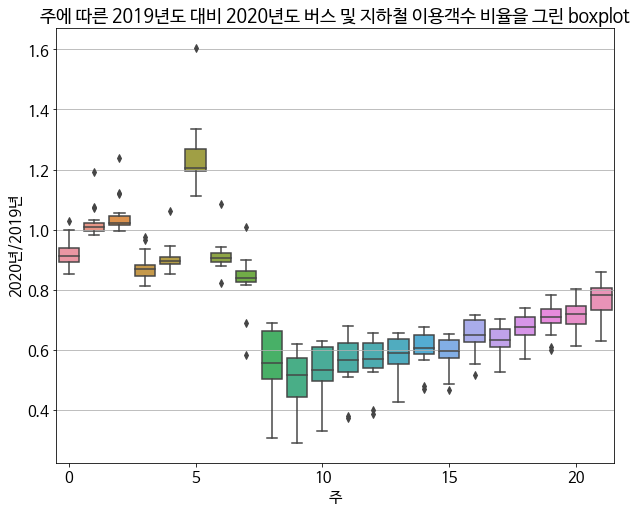

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

plot_region_by_week = data_region_by_week_2020/data_region_by_week_2019
sns.boxplot(data=plot_region_by_week, ax = ax)
ax.set_xlabel("주")
ax.set_ylabel("2020년/2019년")
ax.set_title("주에 따른 2019년도 대비 2020년도 버스 및 지하철 이용객수 비율을 그린 boxplot")
_ = ax.set_xticks(range(0, 22, 5))

위의 box plot을 통해 대부분의 지역에서 비슷한 추이로 사용량이 감소했다가 증가함을 알 수 있다.

다음으로 지역에 따른 회복추세를 예측한 그래프이다.

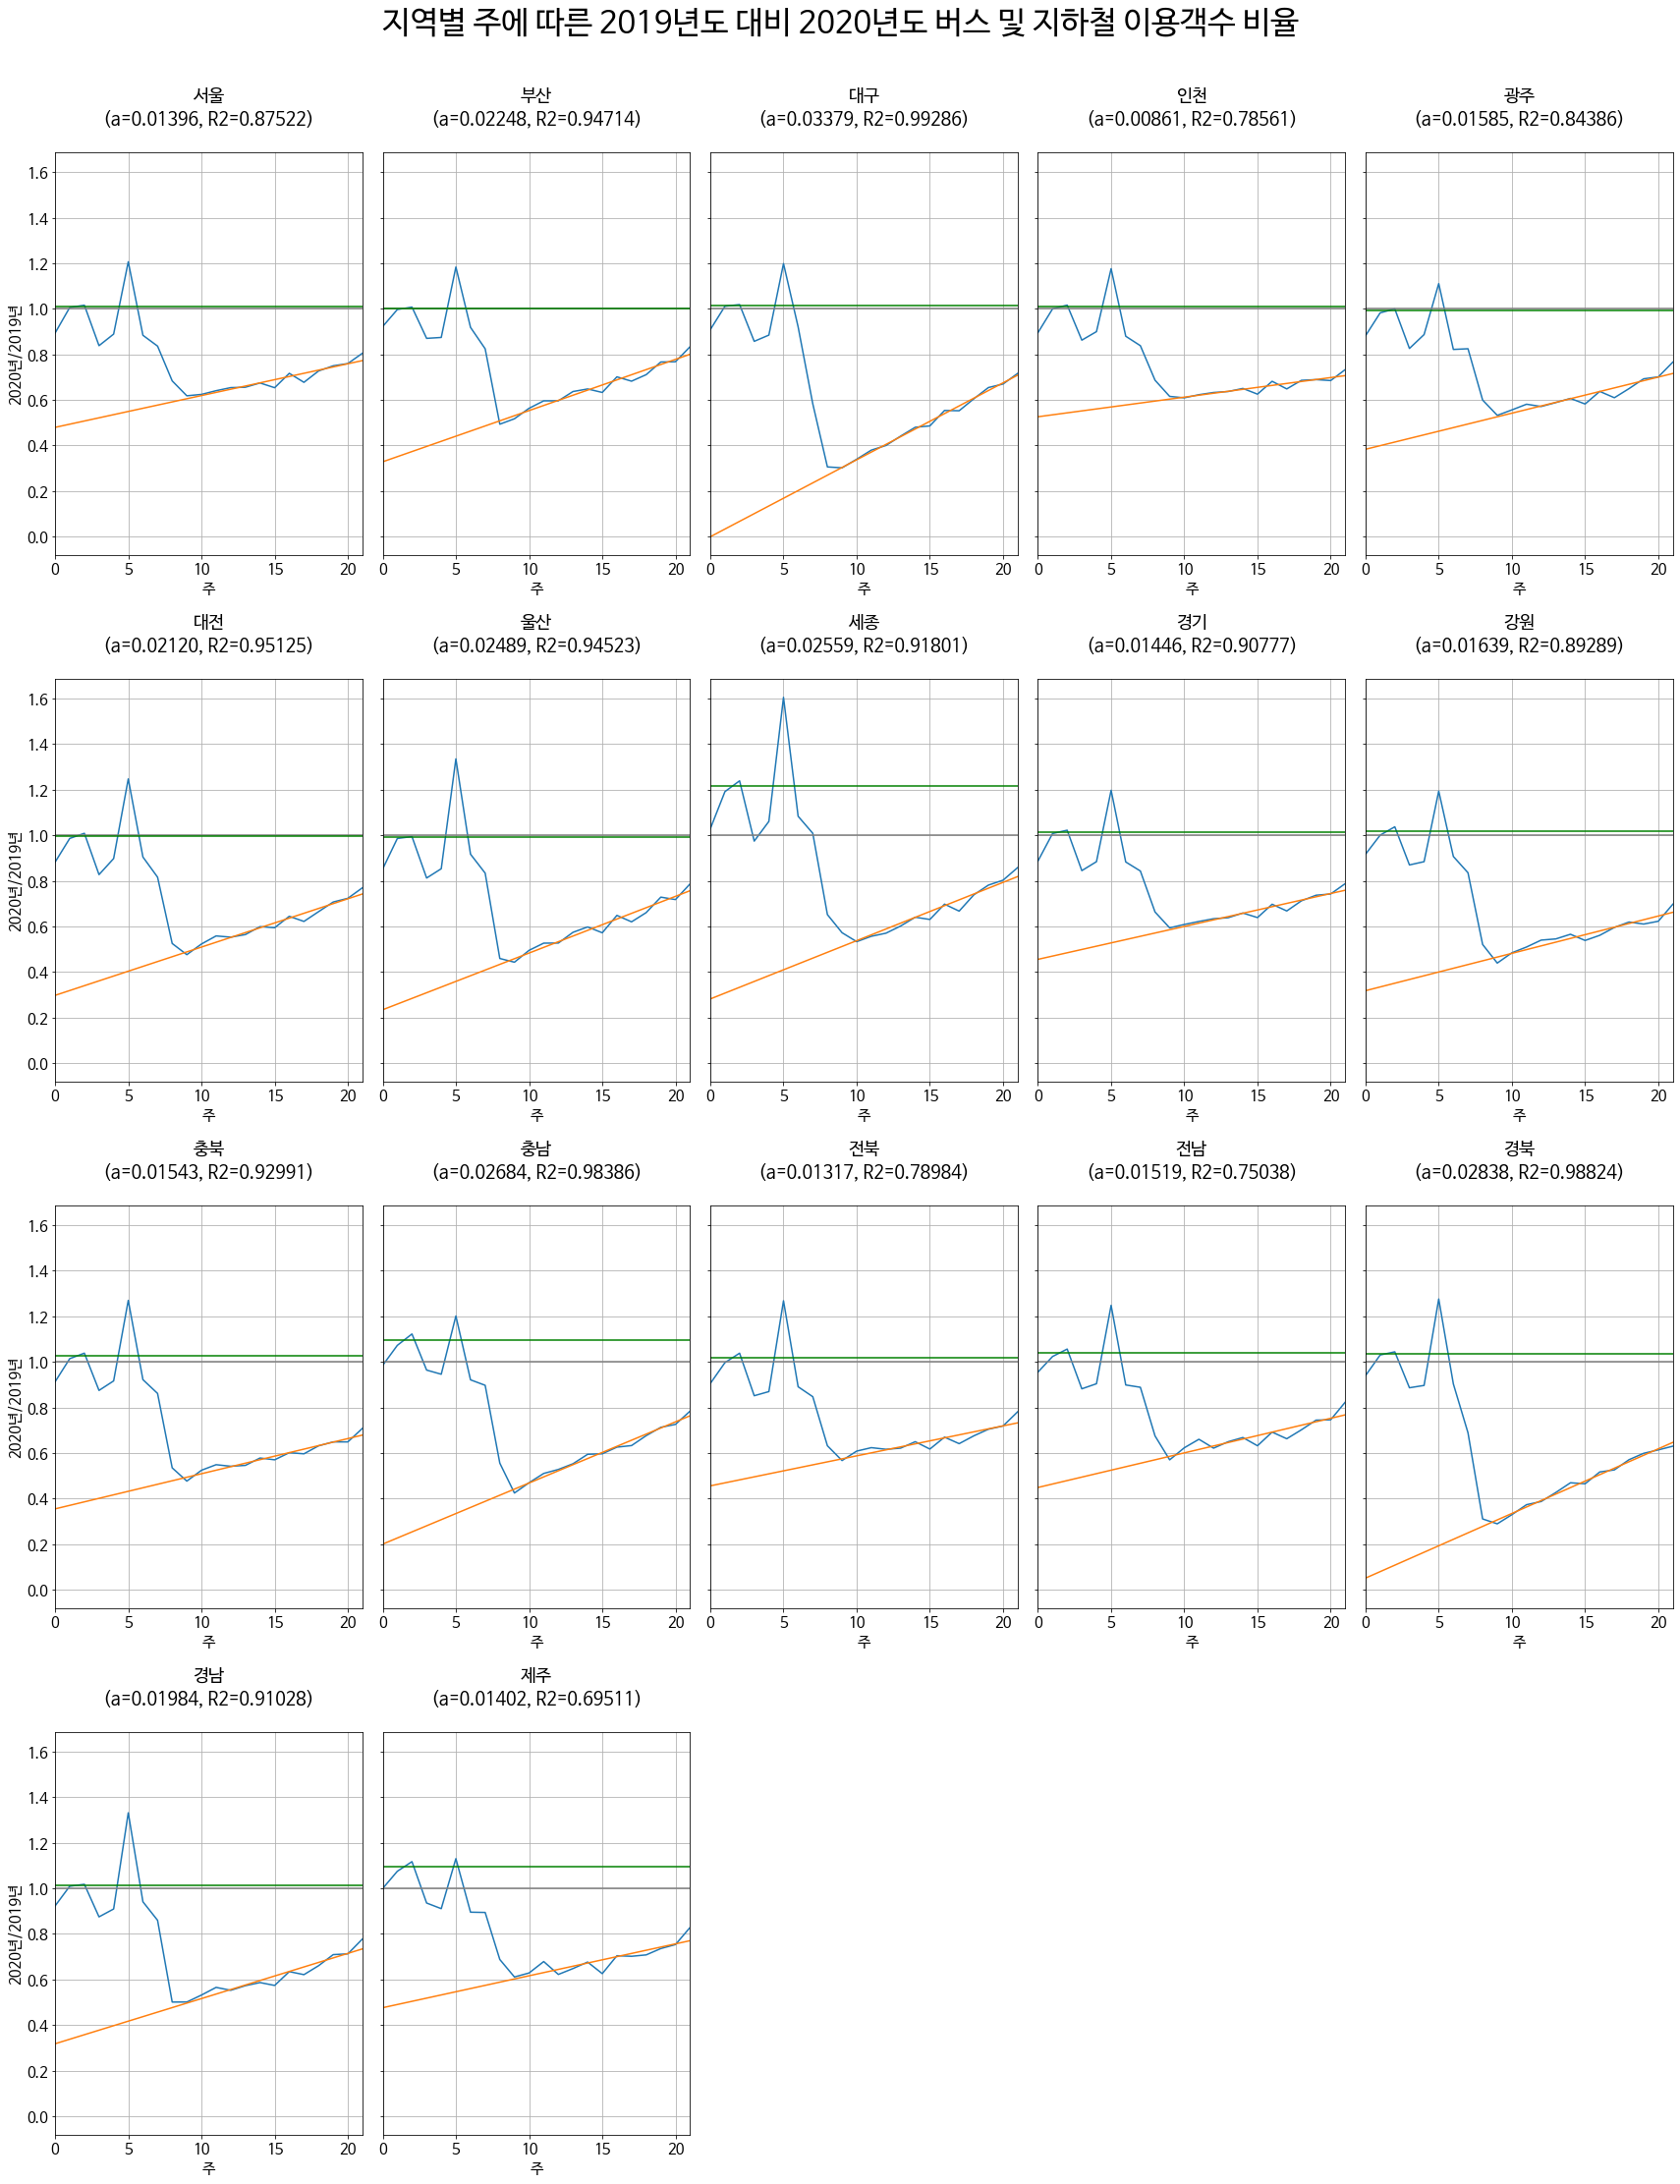

In [15]:
xmin = 0
xmax = 21

a_list = []
b_list = []
base_list = []
R2_list = []

residual = np.zeros((len(code2area), 22-9))

fig, axes = plt.subplots(4, 5, figsize=(24,30), sharey='all')
for idx, (code, name) in enumerate(code2area.items()):
    base_line = sum(data_region_by_week_2020[idx, 1:3])/sum(data_region_by_week_2019[idx, 1:3])

    
    lr = LinearRegression()
    X = np.arange(9, 22)
    Y = plot_region_by_week[idx, 9:]
    
    X = np.expand_dims(X, axis=1)
    lr.fit(X, Y)
    x = np.expand_dims(np.linspace(0, 22, 10), axis=1)
    y = lr.predict(x)
    
    Y_hat = lr.predict(X)
    r2 = r2_score(Y_hat, Y)
    residual[idx] = Y_hat-Y
    
    a_list.append((name, lr.coef_[0]))
    b_list.append((name, lr.intercept_))
    base_list.append((name, base_line))
    R2_list.append((name, r2))
    
    ax = axes[idx//5, idx%5]
    ax.plot(plot_region_by_week[idx, :])
    ax.plot(x, y)
    ax.set_title(f"{name}\n(a={lr.coef_[0]:.5f}, R2={r2:.5f})\n")
    ax.axhline(1, xmin=xmin, xmax = xmax, color="grey")
    ax.axhline(base_line, xmin=xmin, xmax = xmax, color="green")
    ax.grid()
    ax.set_xlim(xmin=xmin, xmax=xmax)
    ax.set_xlabel("주")
    if idx%5==0:
        ax.set_ylabel("2020년/2019년")
for idx in range(len(code2area), 20):
    axes[idx//5, idx%5].axis('off')
plt.tight_layout()
_ = fig.suptitle("지역별 주에 따른 2019년도 대비 2020년도 버스 및 지하철 이용객수 비율",y=1.03, fontsize=32)

위의 그래프를 통해 일부 지역을 제외하고 회복이 높은 선형성을 가지고 있음을 볼 수 있다.

기울기와 baseline(2020년 2주차 3주차의 평균)을 계산하여 회복되는데 필요한 기간을 계산하면 다음과 같다.

In [16]:
recover_time_list = []
for (name, a), (_, b), (_, base), (_, r2) in zip(a_list, b_list, base_list,R2_list):
    recover_time = (base-b)/a
    recover_time_list.append((name, recover_time, r2))
for x in sorted(recover_time_list, key=lambda x: x[1]):
    print(f"{x[0]}: {x[1]:.0f}주(발생일 기준 {x[1]-3:.0f}주뒤) by R2={x[2]:.5f}")

부산: 30주(발생일 기준 27주뒤) by R2=0.94714
대구: 30주(발생일 기준 27주뒤) by R2=0.99286
울산: 30주(발생일 기준 27주뒤) by R2=0.94523
대전: 33주(발생일 기준 30주뒤) by R2=0.95125
충남: 33주(발생일 기준 30주뒤) by R2=0.98386
경북: 35주(발생일 기준 32주뒤) by R2=0.98824
경남: 35주(발생일 기준 32주뒤) by R2=0.91028
세종: 36주(발생일 기준 33주뒤) by R2=0.91801
서울: 38주(발생일 기준 35주뒤) by R2=0.87522
광주: 38주(발생일 기준 35주뒤) by R2=0.84386
경기: 39주(발생일 기준 36주뒤) by R2=0.90777
전남: 39주(발생일 기준 36주뒤) by R2=0.75038
전북: 43주(발생일 기준 40주뒤) by R2=0.78984
강원: 43주(발생일 기준 40주뒤) by R2=0.89289
충북: 44주(발생일 기준 41주뒤) by R2=0.92991
제주: 44주(발생일 기준 41주뒤) by R2=0.69511
인천: 56주(발생일 기준 53주뒤) by R2=0.78561


중간에 큰 변수만 발생하지 않는다면, 짧게는 27주(8월 중순) 길게는 1년이 지나야 완전히 회복되는 것을 알 수 있다.

하지만, 2020년 8월말 현재의 상황처럼 새롭게 대규모 감염이 발생한다면 이 기간은 더욱 길어질 수 있다.

선형회귀의 오차를 분석하는 boxplot을 아래에 그렸다.

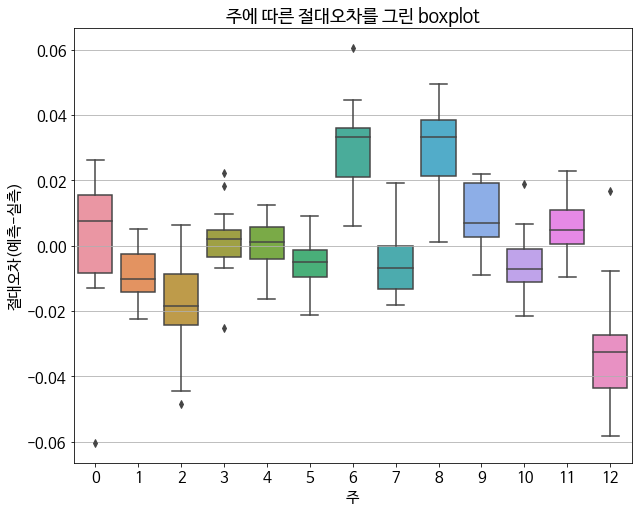

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()
sns.boxplot(data=residual, ax = ax)
ax.set_xlabel("주")
ax.set_ylabel("절대오차(예측-실측)")
_=ax.set_title("주에 따른 절대오차를 그린 boxplot")

맨 마지막 12번째 주(실제론 22주차)에서 실측이 예측에 비해 증가했음을 볼 수 있는데 이는 그동안 미루어졌던 오프라인 개학이 이루어지며 생긴 오차라 짐작된다.

이를 통해 만약 학생들이 움직이게 된다면 회복속도는 더욱 빨라질 것이라 예상할 수 있다.

### 학생의 교통이용 패턴 분석 및 특성 파악

따라서 우리는 학생들의 움직임이 일반 시민들과 시간상으로 어떻게 겹치는지 확인하고자 한다. 이를 위해서 정류장별 이용량 데이터를 통해서 시간에 따른 등하교 시 학생들의 시간에 따른 이동을 확인하였다.

현재 데이터를 확인하고자 하는 것은 등하교 시간의 움직임인데, 이를 위해선 일종의 필터링이 필요하다.

주어진 기간이 방학 기간이고, 모든 학생이 방학이 같지 않다는 점, 그리고 시험 기간 등 다른 요소가 있을 수 있다는 이유로 인해 공휴일을 통해 이를 판단하기는 어렵다.

이를 위해 먼저 시간에 따른 사용량을 정규화시킨 후, umap을 통해 2차원에 임베딩 하고, 이후 dbscan을 통해 클러스터링하여 학생들의 실제 등 하교 일을 찾아보고자 하였다.

In [18]:
code2user = {
    1: "일반인",
    2: "어린이",
    3: "청소년",
    4: "경로",
}

data_for_umap = np.zeros((151, 24))

for idx, date in enumerate(tqdm(date_list)):
    tmp = data_reduced.loc[data_reduced["운행 일자"]==date, ["운행 일자", "시간대","이용자 유형 코드", "승차 인원", "하차 인원"]]
    tmp = tmp.loc[tmp["이용자 유형 코드"]==3, ["운행 일자", "시간대", "승차 인원", "하차 인원"]]
    tmp = tmp.groupby(["운행 일자", "시간대"]).sum().to_pandas().reset_index()
    arr = np.zeros((24,))
    for _, x in tmp.iterrows():
        time = x["시간대"]
        val = x["승차 인원"]+x["하차 인원"]
        arr[time] = val
    data_for_umap[idx, :] = arr

In [19]:
scaled_data_for_umap = StandardScaler().fit_transform(data_for_umap)
reducer = umap.UMAP(random_state=4)
embedding = reducer.fit_transform(scaled_data_for_umap)
clustering = DBSCAN(eps=0.7, min_samples=2).fit(embedding)

/opt/miniconda3/envs/BigData/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


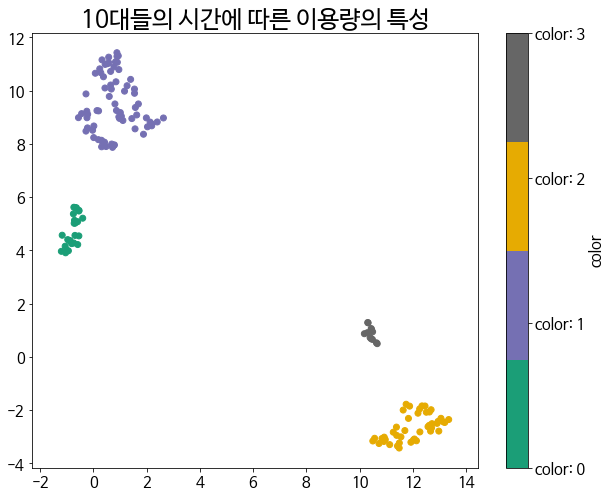

In [20]:
num_fig = max(clustering.labels_)+1
plt.figure(figsize=(10, 8))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=clustering.labels_,
    cmap=plt.cm.get_cmap('Dark2', num_fig))
plt.gca().set_aspect('equal', 'datalim')
plt.title('10대들의 시간에 따른 이용량의 특성', fontsize=24)
_=plt.colorbar(ticks=range(num_fig), format='color: %d', label='color')

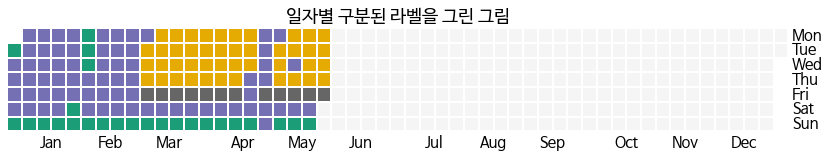

In [21]:
date_idx = pd.date_range(start='1/1/2019', end='5/31/2019')
calmap_data = pd.Series(clustering.labels_, index=date_idx)
f, ax = plt.subplots(1, 1, figsize = (14, 8))
_ = calmap.yearplot(calmap_data, year=2019, ax=ax, cmap = "Dark2")
_ = ax.set_title("일자별 구분된 라벨을 그린 그림")

4월 마지막주에 label 1이 많이 등장하는 것을 볼 수 있는데 이는 시험기간으로 인해 생긴 것으로 파악된다.

각 클러스터별로 평균된 움직임은 다음과 같다.

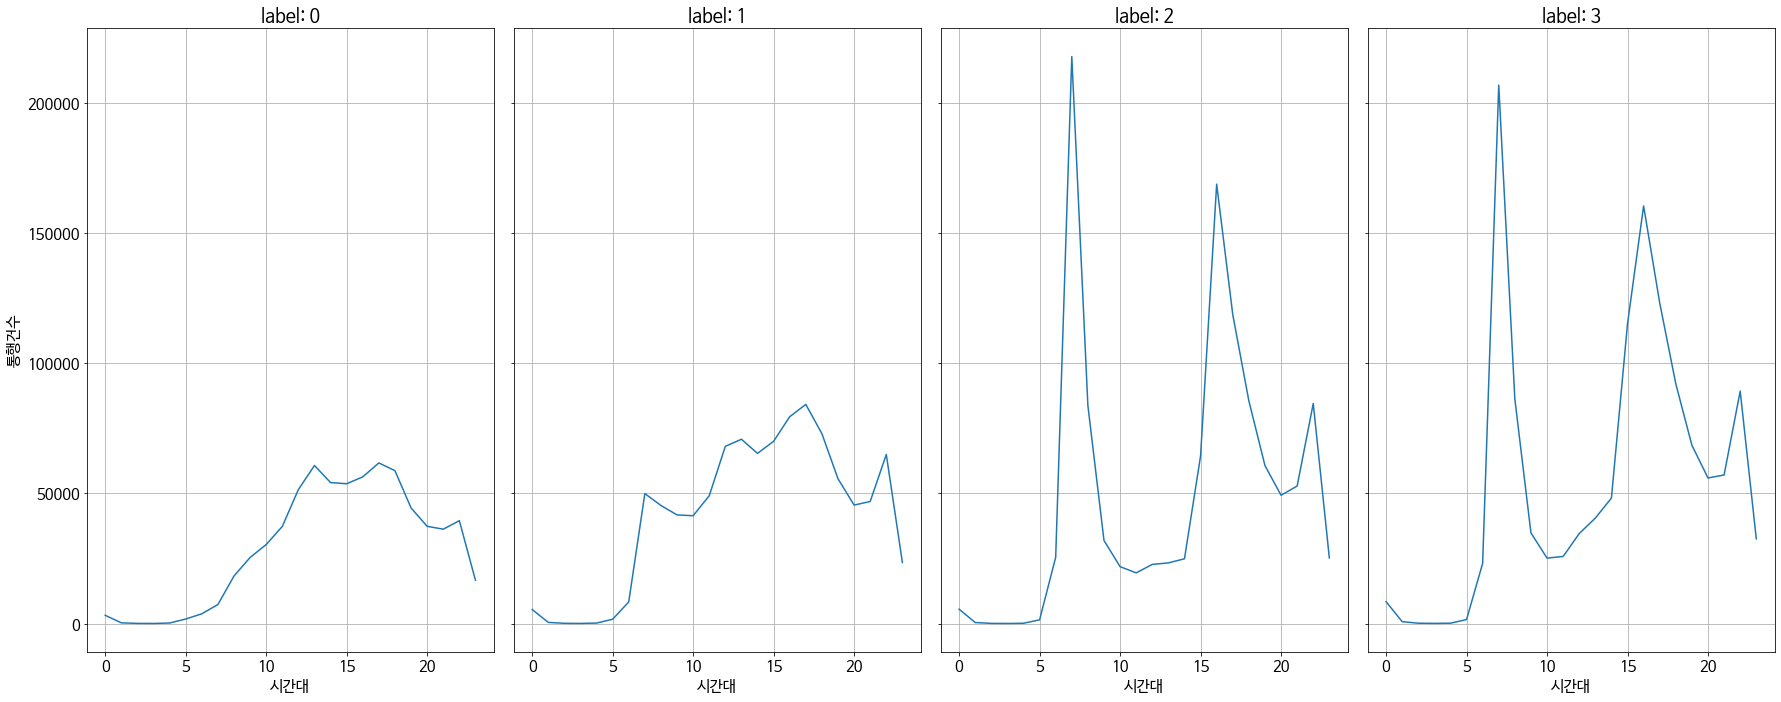

In [22]:
f, axes = plt.subplots(1, num_fig, sharey=True, figsize=(25, 10))
axes[0].set_ylabel("통행건수")
for idx, ax in enumerate(axes):
    data = np.sum(data_for_umap[clustering.labels_==idx, :], axis=0)
    data = data/sum(clustering.labels_==idx)
    ax.plot(data)
    ax.grid()
    ax.set_title(f"label: {idx}")
    ax.set_xlabel("시간대")
    
f.tight_layout()

우리는 등하교하는 라벨을 2와 3으로 결정하였다.

해당하는 라벨을 받은 날짜에 대해서 시간대별로 어떤 연령대의 사람들이 얼마나 이용하는지 분석하였다.

In [23]:
mask = np.logical_or(clustering.labels_==2, clustering.labels_==3)
normal_date = []
for i in range(len(date_list)):
    if mask[i]:
        normal_date.append(date_list[i])

In [24]:
data_by_user_type_on_20190308 = np.zeros((4, 24))
for i in range(1, 4+1):
    tmp = data_reduced.loc[data_reduced["이용자 유형 코드"]==i, ["운행 일자", "시간대", "승차 인원", "하차 인원"]]
    tmp = tmp.loc[tmp["운행 일자"].isin(normal_date), ["시간대", "승차 인원", "하차 인원"]].groupby("시간대").sum().to_pandas().reset_index()
    arr = np.zeros((24,))
    
    for _, x in tmp.iterrows():
        time = x["시간대"]
        val = x["승차 인원"] + x["하차 인원"]
        arr[time] = val
    data_by_user_type_on_20190308[i-1, :] = arr

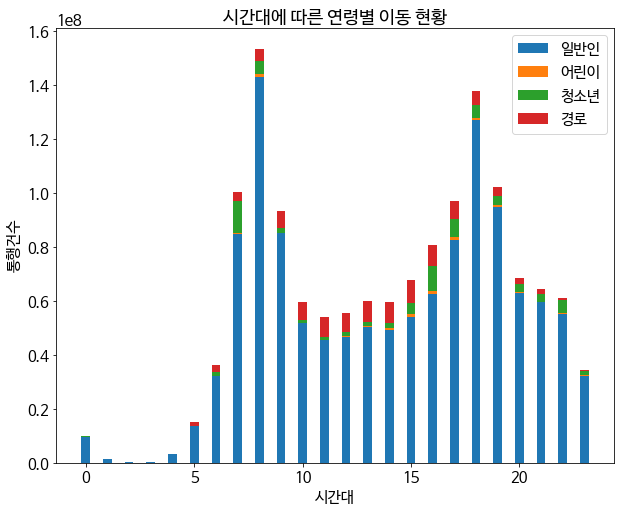

In [25]:
plot_accum_sum = np.add.accumulate(data_by_user_type_on_20190308, axis=0)
ind = np.arange(24)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(10,8))
for idx, x in enumerate(data_by_user_type_on_20190308):
    if idx==0:
        plt.bar(ind, x, width, label=code2user[idx+1])
    else:
        plt.bar(ind, x, width, bottom = plot_accum_sum[idx-1], label=code2user[idx+1])
plt.xlabel("시간대")
plt.ylabel("통행건수")
plt.title("시간대에 따른 연령별 이동 현황")
_ = plt.legend()

이를 통해 학생들이 움직이는 시간에 많은 사람들이 움직이고, 다양성이 높아 감염에 더 취약해질 수 있음을 볼 수 있다.

그러므로 우리는 학생의 교통이용 패턴이 다른 연령대의 집단과 시간적 동선이 많이 겹친다는 가설 1을 채택하였다.

---

## 분석 - 가설 2 검증

### 10대 청소년의 감염 패턴 분석

우리는 대한민국의 집단 감염 케이스에서 전체 확진자 중 10대가 차지하는 비율을 분석해 보았다.


In [26]:
covid = pd.read_csv("data/COVID_19/PatientInfo.csv")
covid["confirmed_date"] = pd.to_datetime(covid["confirmed_date"])

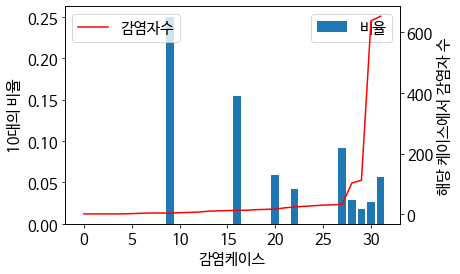

In [27]:
cases = covid["infection_case"].unique()

arr = []
arr2 = []
i=0
for idx, case in enumerate(cases):
    if case == "contact with patient":
        continue
    tmp = covid.loc[covid["infection_case"]==case, ["patient_id", "age"]].groupby(["age"]).count()
    tmp2 = 0
    for idx, x in tmp.iterrows():
        if idx=="10s":
            tmp2 = x["patient_id"]
    if np.sum(tmp["patient_id"].values)!=0:
        arr.append(tmp2 / np.sum(tmp["patient_id"].values))
        arr2.append(np.sum(tmp["patient_id"].values))
    i+=1
tmp = list(zip(arr, arr2))
tmp = sorted(tmp, key= lambda x: x[1])
arr = [x[0] for x in tmp]
arr2 = [x[1] for x in tmp]
fig, ax1 = plt.subplots()
ax1.bar(x = range(len(arr)), height=arr, label="비율")
ax2 = ax1.twinx()
ax2.plot(range(len(arr)), arr2, color="red", label="감염자수")
ax1.set_xlabel("감염케이스")
ax1.set_ylabel("10대의 비율")
ax2.set_ylabel("해당 케이스에서 감염자 수")
ax1.legend()
_ = ax2.legend()

확진자가 가장 많이 형성된 감염 케이스 중 10대의 비율은 최대 25%을 넘기지 못함을 알 수 있다.

10대 감염자가 가장 많은 첫번째와 두번째 케이스는 "Changnyeong Coin Karaoke" 와 "Seongdong-gu APT" 케이스이다.



### 최초 감염자의 나이대 분포 및 각 최초 감염자 별 2차 감염자 클러스터의 규모 분석

대한민국에서 발생한 집단 감염 케이스의 최초 감염자 나이대의 분포를 분석해 보았고, 각 최초 감염자로 부터 형성된 2차 감염자 클러스터의 규모를 분석하였다.


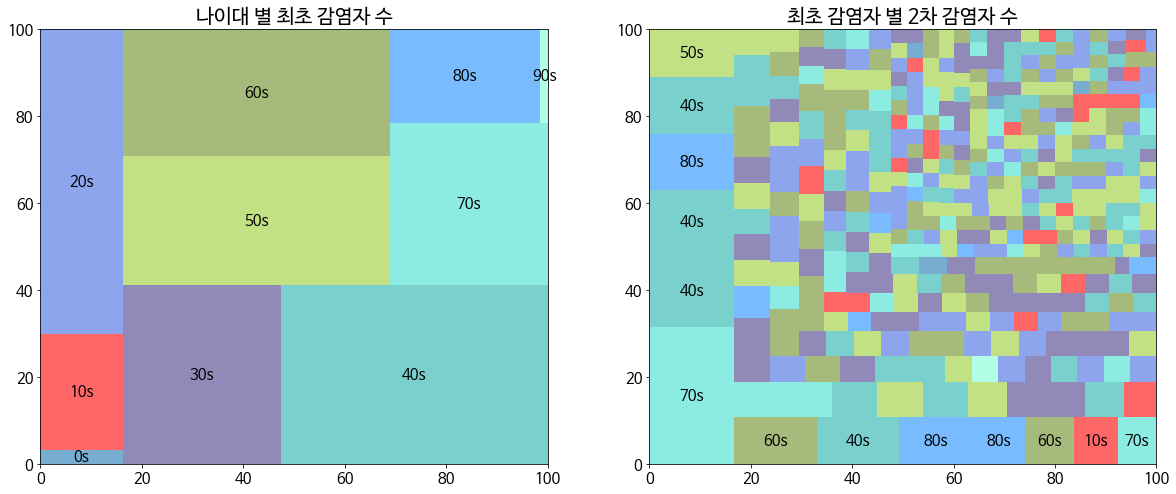

In [28]:
c19_patientinfo_columns = [
    "환자 ID", "환자 성별", "환자 나이", "환자 국가", "환자 지방", "환자 도시", 
    "감염 경로", 
    "환자를 감염시킨 사람의 ID", "사람들과의 접촉 수", 
    "증상이 시작된 날짜", "확진 날짜", "퇴원 날짜", "사망한 날짜", "격리상태"
]
c19_patientinfo = pd.read_csv("data/COVID_19/PatientInfo.csv", sep=",", header=None, names=c19_patientinfo_columns)
c19_patientinfo = c19_patientinfo[1:]
c19_contact_id = list(c19_patientinfo["환자를 감염시킨 사람의 ID"].dropna())

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import squarify

counts = Counter(c19_contact_id).most_common()
ids = [item[0] for item in counts]
num = [item[1] for item in counts]
nbars = len(counts)

def age_from_id(id_str):
    return c19_patientinfo[c19_patientinfo['환자 ID']==id_str]['환자 나이'].tolist()

age_of_ids = list(map(age_from_id, ids))
num_per_age = [0]*11

for i, age_arr in enumerate(age_of_ids) :
    if len(age_arr) == 1 and type(age_arr[0]) == str :        
        num_per_age[int(age_arr[0][:-1])//10] += num[i]

        
plt.figure(figsize=(20,8))

plt.subplot(121)
colors=[
    'tab:blue', 'red', 'royalblue', 'darkslateblue', 'lightseagreen',
    'yellowgreen', 'olivedrab', 'turquoise',  'dodgerblue', 'aquamarine', 'lightblue'
]       
squarify.plot(sizes=num_per_age[:-1], label=[f'{x*10}s' for x in range(0,10)], alpha=0.6, color=colors)
plt.title('나이대 별 최초 감염자 수', fontsize=20)


agez = []
numz = []
clrz = []

for i, age_arr in enumerate(age_of_ids) :
    if len(age_arr) == 1 and type(age_arr[0]) == str :
        clrz.append(colors[int(age_arr[0][:-1])//10])
        agez.append(age_arr[0])
        numz.append(num[i])

plt.subplot(122)
squarify.plot(sizes=numz, label=agez[:13], alpha=0.6, color=clrz)
plt.title('최초 감염자 별 2차 감염자 수', fontsize=20)
plt.show()

좌측 트리 맵에서 각 직사각형 셀은 나이대별 최초 전파자의 수를 의미한다.

최초 전파자의 나이대는 20~80대의 연령층에 비해 10대의 나이인 케이스는 매우 적음을 알 수 있다.

우측 트리 맵에서 각 직사각형 셀은 최초 감염자 한 명으로 인한 클러스터의 규모(2차 감염자의 수)를 의미한다.

중년 및 장년의 나이대 최초 감염자의 경우 클러스터의 규모가 큰 것에 비해, 최초 감염자가 10대인 경우의 클러스터는 그 규모가 매우 적음을 알 수 있다.



그러므로 우리는 청소년의 코로나 확진의 주 근원은 타인으로부터의 감염이고, 최초 감염자인 청소년은 타 연령대보다 클러스터의 규모가 작다는 가설 2를 채택하였다.

---

## 정책 제안 및 기대효과

위의 데이터 분석 및 가설 검증을 통해서 우리는 다음과 같은 사실을 알 수 있었다.

1. 2019년과 2020년의 버스 및 지하철 이용량을 분석한 결과, 코로나19 발생 이후부터 대부분의 지역에서 2020년의 버스 및 지하철 이용량이 감소하였다. 이에 따라서 지역별 이용량 회복추세를 살펴본 결과, 다른 변수가 없는 가정하에서 짧게는 27주부터 길게는 1년이 지나야 대중교통 이용량이 회복된다는 것을 알 수 있었다. 이러한 회복속도의 추세라면 지하철 및 버스 내에서도 코로나19 감염이 일어날 가능성이 있으므로, 이로부터 10대 학생을 보호하기 위해서 우리는 학생의 대중교통 이용 패턴과 특성을 파악해보았다. 해당 특성을 파악한 결과, 10대의 경우에는 오전 7시-오전 9시 사이, 오후 3시-오후 5시 사이에 대중교통을 자주 이용한다는 것을 알 수 있었다. 또한, 해당 시간에는 학생뿐만이 아니라 다른 시민들도 대중교통을 많이 이용하므로,  교통이용 패턴이 다른 연령대의 집단과 시간적 동선이 많이 겹친다는 것을 유추할 수 있었다.
2. 10대의 경우 20\~80대보다 최초 감염자의 수가 적다. 이를 통해 10대의 경우 타인으로부터의 감염이 가장 큰 확진 요인임을 알 수 있었다. 또한 통행 건수가 비교적 적은 중년 및 장년층보다 10\~30대의 최초 감염자로부터 형성된 2차 감염자 클러스터의 규모가 작게 확인이 된다는 것은,  10\~30대의 최초 감염자의 경우 동선 추적의 어려움이 있어 이른바 '깜깜이 감염'을 더 쉽게 형성할 수 있다는 것을 의미한다. 이를 통해 젊은 세대의 동선을 최대한 분리 및 관리하여 동선의 복잡성을 낮추는 것이 '깜깜이 감염'을 예방할 수 있는 좋은 솔루션이 될 수 있음을 유추할 수 있었다.


이에 따라 우리는 코로나19 상황에서 버스와 지하철을 사람들이 많이 이용하지 않는 이유가 대중교통에 탑승하는 사람이 불분명하고, 이로 인해 다른 사람과 어떤 접촉이 일어날지 모르기 때문이라고 생각하였다. 학교로 등하교를 하는 학생의 경우 이러한 대중교통에 의존할 수밖에 없는데, 학생들이 등하교하는 시간에는 다른 시민들도 대중교통을 많이 이용하므로 학생과 모르는 사람과 접촉할 가능성이 커지게 된다. 그러므로, 우리는 10대 학생들이 버스 및 지하철에서 코로나19로부터 감염될 확률이 높다고 판단하여, 학생을 대상으로 한 카풀 형태의 셔틀버스 시스템을 제안하고자 한다. 해당 시스템은 셔틀버스 탑승 집단을 10대 학생으로 제한하고, 노선은 학생 및 학생이 다수 거주하는 지역으로 한정한다. 이러한 셔틀버스 시스템은 다음과 같은 기대효과가 있다.

1. 해당 셔틀버스 시스템은 10대 학생이라는 특정한 그룹의 사람만 이용할 수 있어서 대중교통의 '모르는 사람과의 접촉' 문제를 해결하는 데 큰 도움을 준다. 따라서, 어떤 특정 집단에 코로나19가 발생하더라도, 기존의 대중교통과는 다르게 해당 집단을 분리하는데 용이하여 이에 따른 감염 위험성을 줄일 수 있다.
2. 위와 같이 10대 학생이라는 특정 집단을 분리하게 되면, 해당 집단의 이동 경로 및 방문 경로를 단순화시킬 수 있다. 이를 통해서 각 집단의 복잡도를 낮출 수 있고, 해당 집단의 사용자가 어떤 경로로 이동했는지 쉽게 파악할 수 있다.

## 라이센스
Copyright 2020 포로나


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions andlimitations under the License.